# SCIALOG Statistical Analyses

Steps 1 - 3

In [2]:
import os
import seaborn as sns

# Climb up to the project root if currently inside a subdirectory
while os.path.basename(os.getcwd()) != "NICO_human-gemini":
    os.chdir("..")

print("Working directory:", os.getcwd())

Working directory: /Users/maxchalekson/NICO-Research/NICO_human-gemini


In [3]:
# Set theme globally (do this once at the top of your notebook)
sns.set_theme(style="whitegrid", palette="colorblind")

## STEPS 1-2

### Max and Evey (code)

In [4]:
import pandas as pd

def process_flat_sheet(filepath, coder_name):
    xls = pd.read_excel(filepath, sheet_name=None)
    all_dfs = []

    for sheet_name, df in xls.items():
        df.columns = [str(c).strip().lower() for c in df.columns]
        if not {'video', 'timestamp', 'speaker'}.issubset(df.columns):
            continue
        for i in range(4):  # Annotation columns are every other, starting from index 3
            annot_idx = 3 + i * 2
            if annot_idx >= len(df.columns):
                continue
            code_col = df.columns[annot_idx]
            temp = df[['video', 'timestamp', 'speaker', code_col]].copy()
            temp.columns = ['video', 'timestamp', 'speaker', 'annotation']
            temp['coder'] = coder_name
            temp['sheet'] = sheet_name
            all_dfs.append(temp.dropna(subset=['annotation']))
    return pd.concat(all_dfs, ignore_index=True)

# Load Max and Evey data
df_max = process_flat_sheet("Data/sampled video verification (Max).xlsx", "max")
df_evey = process_flat_sheet("Data/sampled video verification (Evey).xlsx", "evey")


### Gemini (code)

In [5]:
import json

def process_gemini_json(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)

    all_rows = []
    skipped_chunks = 0
    all_speakers = set()

    for video, chunks in data.items():
        for chunk_name, utterances in chunks.items():
            if not utterances or not isinstance(utterances, list):
                skipped_chunks += 1
                continue

            for utt in utterances:
                speaker = utt.get("speaker", "").strip()
                timestamp = utt.get("timestamp", "").strip()
                annotations = utt.get("annotations", [])
                video_name = chunk_name.split("/")[0]
                all_speakers.add(speaker)

                if isinstance(annotations, list):
                    for ann in annotations:
                        if isinstance(ann, dict):
                            for label, explanation in ann.items():
                                all_rows.append({
                                    "video": video_name,
                                    "timestamp": timestamp,
                                    "speaker": speaker,
                                    "annotation": label.strip(),
                                    "explanation": str(explanation).strip(),
                                    "coder": "gemini"
                                })
                elif isinstance(annotations, dict):
                    for label, explanation in annotations.items():
                        all_rows.append({
                            "video": video_name,
                            "timestamp": timestamp,
                            "speaker": speaker,
                            "annotation": label.strip(),
                            "explanation": str(explanation).strip(),
                            "coder": "gemini"
                        })

    df = pd.DataFrame(all_rows)
    print(f"\nGemini annotations loaded: {len(df)}")
    print(f"Unique speakers (Gemini): {len(all_speakers)}")
    print(f"Skipped malformed/empty chunks: {skipped_chunks}\n")
    print("Gemini annotation counts:")
    print(df['annotation'].value_counts())
    return df

df_gemini = process_gemini_json("Data/sampled_verification.json")



Gemini annotations loaded: 434
Unique speakers (Gemini): 141
Skipped malformed/empty chunks: 3

Gemini annotation counts:
annotation
expand on existing idea              99
explain or define term or concept    78
present new idea                     60
provide supporting evidence          52
propose decision                     30
ask clarifying question              29
acknowledge contribution             25
express enthusiasm                   15
express agreement                    14
encourage particpatioin              12
assign task                           5
reject idea                           3
offer constructive criticism          3
express frustation                    2
express alternative decision          2
confirm decision                      2
summarize key ideas                   1
express frustration                   1
express humor                         1
Name: count, dtype: int64


## Frequency Plot & Statistics (Max, Evey, Gemini)


Max annotation count statistics:
count    17.000000
mean     11.176471
std      11.822834
min       1.000000
25%       4.000000
50%       7.000000
75%      12.000000
90%      22.200000
max      49.000000
Name: count, dtype: float64


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_52586/1228008109.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


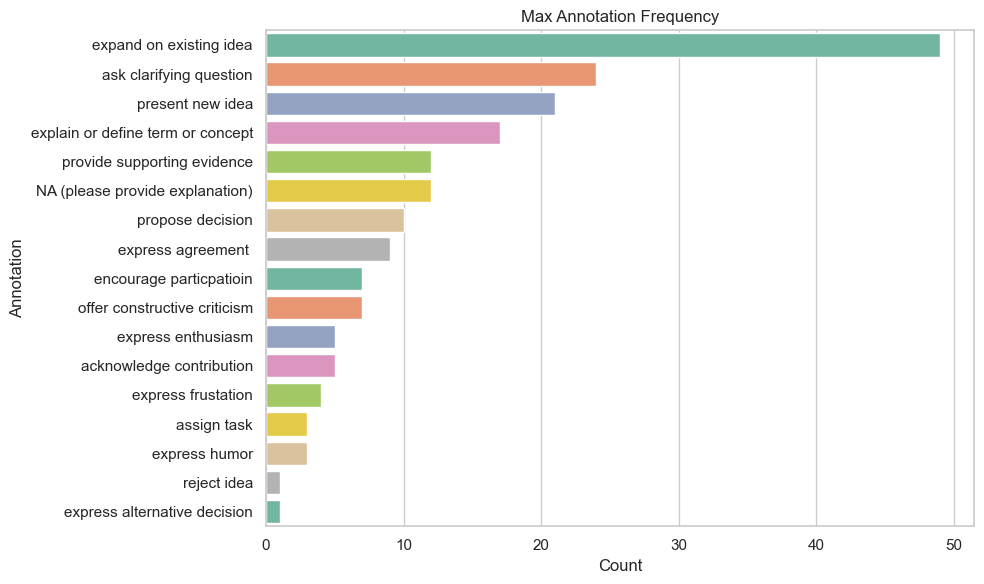


Evey annotation count statistics:
count    14.000000
mean     17.285714
std      14.018826
min       1.000000
25%      10.250000
50%      14.000000
75%      21.000000
90%      34.100000
max      51.000000
Name: count, dtype: float64


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_52586/1228008109.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


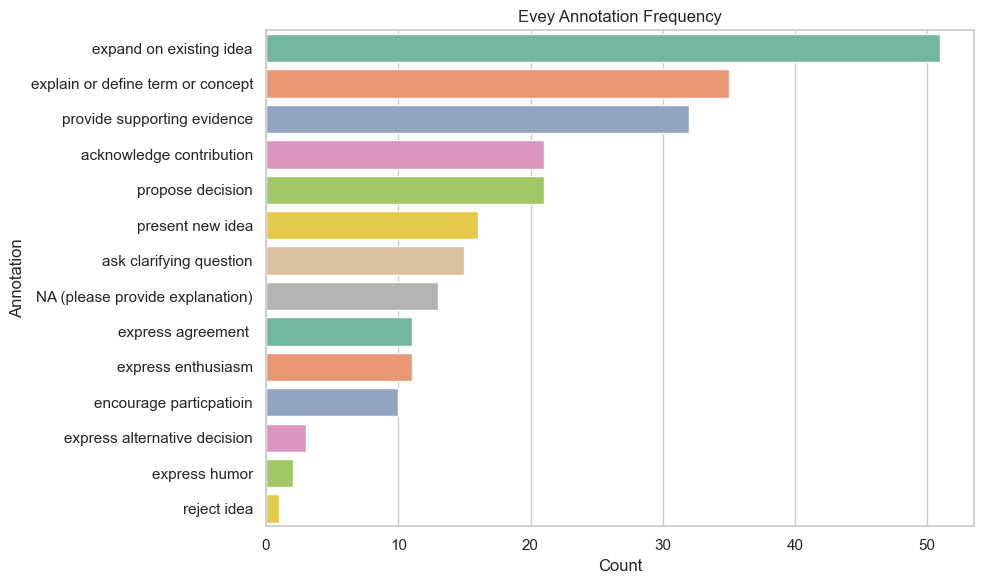

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_52586/1228008109.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(



Gemini annotation count statistics:
count    19.000000
mean     22.842105
std      29.120942
min       1.000000
25%       2.000000
50%      12.000000
75%      29.500000
90%      63.600000
max      99.000000
Name: count, dtype: float64


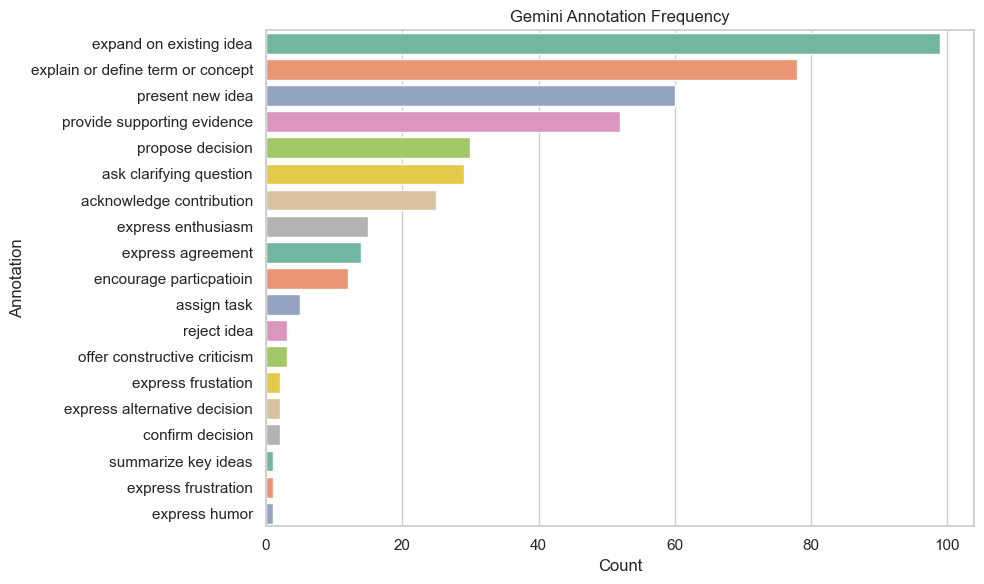

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_annotation_stats(df, coder_name):
    print(f"\n{coder_name} annotation count statistics:")
    print(df['annotation'].value_counts().describe(percentiles=[.25, .5, .75, .9]))

    plt.figure(figsize=(10, 6))
    sns.countplot(
        data=df,
        y='annotation',
        order=df['annotation'].value_counts().index,
        palette='Set2'
    )
    plt.title(f"{coder_name} Annotation Frequency")
    plt.xlabel("Count")
    plt.ylabel("Annotation")
    plt.tight_layout()
    plt.show()

plot_annotation_stats(df_max, "Max")
plot_annotation_stats(df_evey, "Evey")
plot_annotation_stats(df_gemini, "Gemini")


## Co-Occurence Matrix and Heatmap (Max, Evey, Gemini)

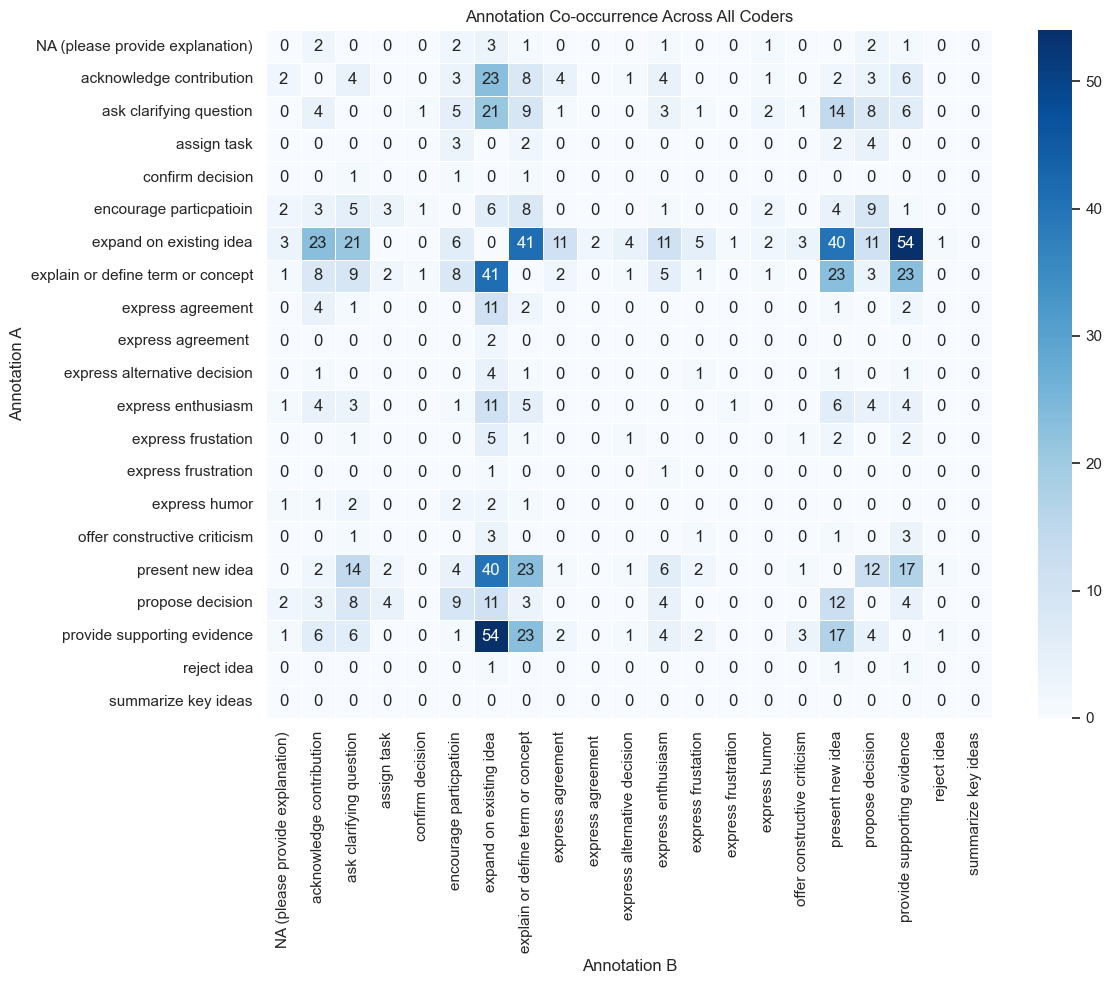

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Combine all annotations
df_all = pd.concat([df_max, df_evey, df_gemini], ignore_index=True)

# Create a unique utterance ID
df_all['utterance_id'] = df_all['video'] + "_" + df_all['timestamp'] + "_" + df_all['speaker'].fillna("")

# Pivot to wide binary format
co_occurrence_df = pd.crosstab(df_all['utterance_id'], df_all['annotation'])

# Compute co-occurrence matrix
co_matrix = co_occurrence_df.T.dot(co_occurrence_df)

# Remove self-co-occurrence on the diagonal
for i in co_matrix.index:
    co_matrix.loc[i, i] = 0

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_matrix, cmap="Blues", annot=True, fmt="d", linewidths=0.5)

plt.title("Annotation Co-occurrence Across All Coders")
plt.xlabel("Annotation B")
plt.ylabel("Annotation A")
plt.tight_layout()
plt.show()


## Cohen's Kappa Calculation (Quadratically Weighted, Steps 2-3)

In [8]:
from sklearn.metrics import cohen_kappa_score
import pandas as pd

# 1. Clean Gemini fields
def clean_gemini_fields(df):
    df['video'] = df['video'].astype(str).str.replace('.mp4', '', regex=False).str.lower().str.strip()
    df['speaker'] = df['speaker'].astype(str).str.lower().str.strip()
    df['timestamp'] = df['timestamp'].astype(str).str.replace('[\[\]]', '', regex=True).str.strip()
    return df

# 2. Clean human coder 'video' fields to match Gemini format
def clean_video_filename(df):
    df['video'] = df['video'].astype(str)
    df['video'] = df['video'].str.extract(r'([^/\\]+)$')[0]  # take last part of path
    df['video'] = df['video'].str.replace(r'\.mp4.*$', '', regex=True)
    df['video'] = df['video'].str.replace(r'\?.*$', '', regex=True)
    df['video'] = df['video'].str.lower().str.strip()

    # 🔧 REMOVE _chunkX if present (to match Gemini)
    df['video'] = df['video'].str.replace(r'_chunk\d+', '', regex=True)

    return df



# 3. Create consistent utterance_id
def add_clean_utterance_id(df):
    return df.assign(
        utterance_id=(
            df['video'].astype(str).str.lower().str.strip() + "_" +
            df['timestamp'].astype(str).str.replace(r'[\[\]\s]', '', regex=True) + "_" +
            df['speaker'].astype(str).str.lower().str.strip()
        )
    )

# === Apply cleaning functions ===
df_max = clean_video_filename(df_max)
df_evey = clean_video_filename(df_evey)
df_gemini = clean_gemini_fields(df_gemini)

df_max = add_clean_utterance_id(df_max)
df_evey = add_clean_utterance_id(df_evey)
df_gemini = add_clean_utterance_id(df_gemini)

# 4. Compute Cohen’s Kappa by code
from sklearn.metrics import cohen_kappa_score

# Turn semicolon-separated annotation strings into lists
def split_annotations(df):
    df['annotation'] = df['annotation'].astype(str).str.lower().str.strip()
    df['annotation_list'] = df['annotation'].str.split(r';\s*')  # split on "; "
    return df

df_max = split_annotations(df_max)
df_evey = split_annotations(df_evey)
df_gemini = split_annotations(df_gemini)

# Multi-label Kappa function
def compute_multilabel_kappa(df1, df2, label1="coder1", label2="coder2", show_examples=True):
    merged = df1[['utterance_id', 'annotation_list']].merge(
        df2[['utterance_id', 'annotation_list']],
        on='utterance_id',
        suffixes=(f"_{label1}", f"_{label2}")
    )

    print(f"\nCohen's Kappa (multi-label presence/absence): {label1} vs {label2}")
    print(f"→ Overlapping utterances: {len(merged)}")

    if len(merged) == 0:
        print("\n No overlapping utterances. Here's a sample of mismatched IDs:")
        unmatched = pd.merge(
            df1[['utterance_id']], df2[['utterance_id']],
            on='utterance_id', how='outer', indicator=True
        )
        print(unmatched[unmatched['_merge'] != 'both'].sample(5, random_state=1))
        return

    if show_examples:
        print("\nSample of merged multi-label annotations:")
        print(merged.head(5))

    # Union of all unique codes
    all_codes = set()
    for col in [f'annotation_list_{label1}', f'annotation_list_{label2}']:
        all_codes.update(code for lst in merged[col] for code in lst)

    print("\nPer-code Cohen's Kappa (multi-label):")
    for code in sorted(all_codes):
        bin1 = merged[f'annotation_list_{label1}'].apply(lambda lst: int(code in lst))
        bin2 = merged[f'annotation_list_{label2}'].apply(lambda lst: int(code in lst))
        score = cohen_kappa_score(bin1, bin2)
        print(f"{code:<35}: {score:.3f}")


# 5. Run comparisons
compute_multilabel_kappa(df_max, df_evey, label1="max", label2="evey")
compute_multilabel_kappa(df_max, df_gemini, label1="max", label2="gemini")
compute_multilabel_kappa(df_evey, df_gemini, label1="evey", label2="gemini")


# 6. Optional: inspect samples
print("\nSample Gemini utterance_ids:")
print(df_gemini['utterance_id'].drop_duplicates().sample(5, random_state=42).to_list())

print("\nSample Max utterance_ids:")
print(df_max['utterance_id'].drop_duplicates().sample(5, random_state=42).to_list())

print("\nSample Evey utterance_ids:")
print(df_evey['utterance_id'].drop_duplicates().sample(5, random_state=42).to_list())



Cohen's Kappa (multi-label presence/absence): max vs evey
→ Overlapping utterances: 373

Sample of merged multi-label annotations:
                                        utterance_id  \
0  breakout_room_4_part_2_2021_04_22_13_14_53_00:...   
1                      nan_01:01-02:30_nandita garud   
2                         nan_03:00-03:34_mark mimee   
3  breakout_room_4_part_2_2021_04_22_13_14_53_07:...   
4  breakout_room_4_part_2_2021_04_22_13_14_53_07:...   

                   annotation_list_max               annotation_list_evey  
0           [acknowledge contribution]         [acknowledge contribution]  
1                   [present new idea]  [na (please provide explanation)]  
2            [ask clarifying question]          [expand on existing idea]  
3  [explain or define term or concept]          [ask clarifying question]  
4  [explain or define term or concept]                 [present new idea]  

Per-code Cohen's Kappa (multi-label):
acknowledge contribution           :

<>:8: SyntaxWarning: invalid escape sequence '\['
<>:8: SyntaxWarning: invalid escape sequence '\['
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_52586/1372865870.py:8: SyntaxWarning: invalid escape sequence '\['
  df['timestamp'] = df['timestamp'].astype(str).str.replace('[\[\]]', '', regex=True).str.strip()


## STEP 3

### Per-code Frequency Counts & Bar Plots

Max - Annotation Counts:
 annotation
expand on existing idea              49
ask clarifying question              24
present new idea                     21
explain or define term or concept    17
provide supporting evidence          12
na (please provide explanation)      12
propose decision                     10
express agreement                     9
encourage particpatioin               7
offer constructive criticism          7
express enthusiasm                    5
acknowledge contribution              5
express frustation                    4
assign task                           3
express humor                         3
reject idea                           1
express alternative decision          1
Name: count, dtype: int64 

Evey - Annotation Counts:
 annotation
expand on existing idea              51
explain or define term or concept    35
provide supporting evidence          32
acknowledge contribution             21
propose decision                     21
present new idea 

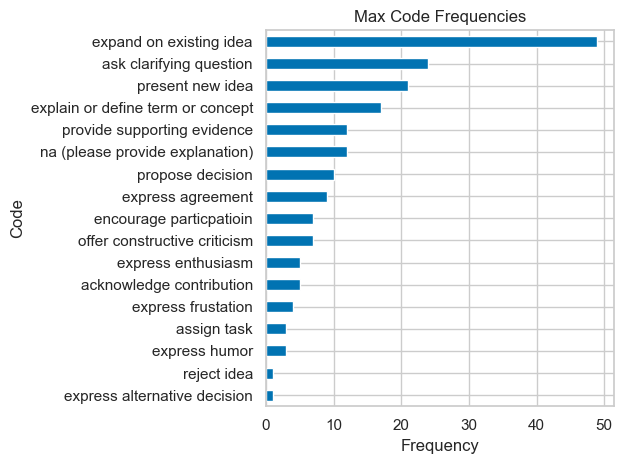

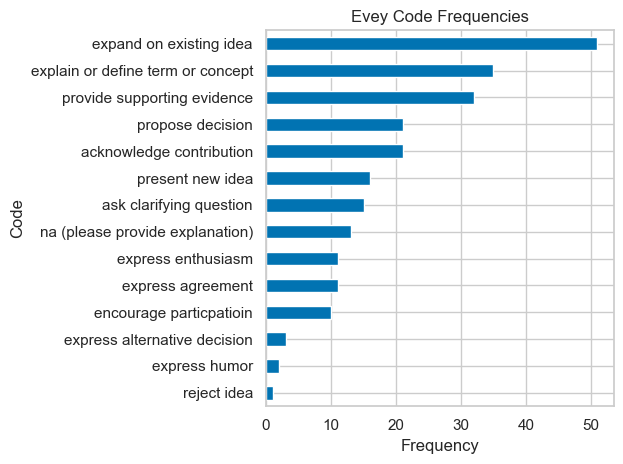

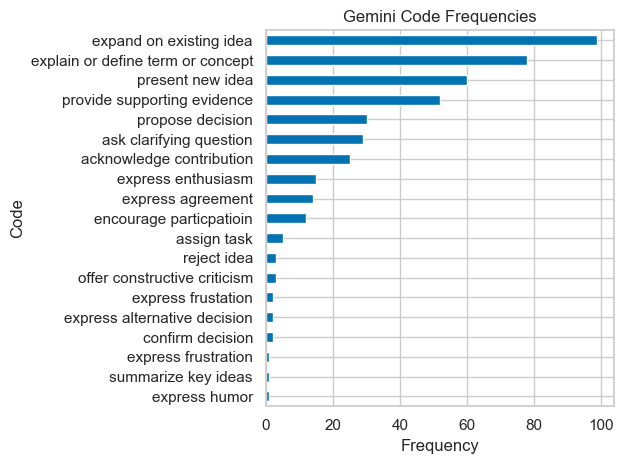

In [17]:
# 3a. Code frequency counts
print("Max - Annotation Counts:\n", df_max['annotation'].value_counts(), "\n")
print("Evey - Annotation Counts:\n", df_evey['annotation'].value_counts(), "\n")
print("Gemini - Annotation Counts:\n", df_gemini['annotation'].value_counts(), "\n")

# 3b. Bar plots for visual comparison
import matplotlib.pyplot as plt

for df, name in [(df_max, "Max"), (df_evey, "Evey"), (df_gemini, "Gemini")]:
    df['annotation'].value_counts().sort_values().plot(kind='barh', title=f"{name} Code Frequencies")
    plt.xlabel("Frequency")
    plt.ylabel("Code")
    plt.tight_layout()
    plt.show()


## Google Doc Uploaded Charts

## Part 1A


 Code Frequency Stats for Max


,code,count,mean_per_utterance,median_per_utterance,std_per_utterance
4,expand on existing idea,49,1.0,1.0,0.0
2,ask clarifying question,24,1.0,1.0,0.0
1,present new idea,21,1.0,1.0,0.0
3,explain or define term or concept,17,1.0,1.0,0.0
8,provide supporting evidence,12,1.0,1.0,0.0
12,na (please provide explanation),12,1.0,1.0,0.0
13,propose decision,10,1.0,1.0,0.0
14,express agreement,9,1.0,1.0,0.0
5,encourage particpatioin,7,1.0,1.0,0.0
7,offer constructive criticism,7,1.0,1.0,0.0


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_31697/2441088057.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='code', x='count', data=df_stats, palette='viridis')


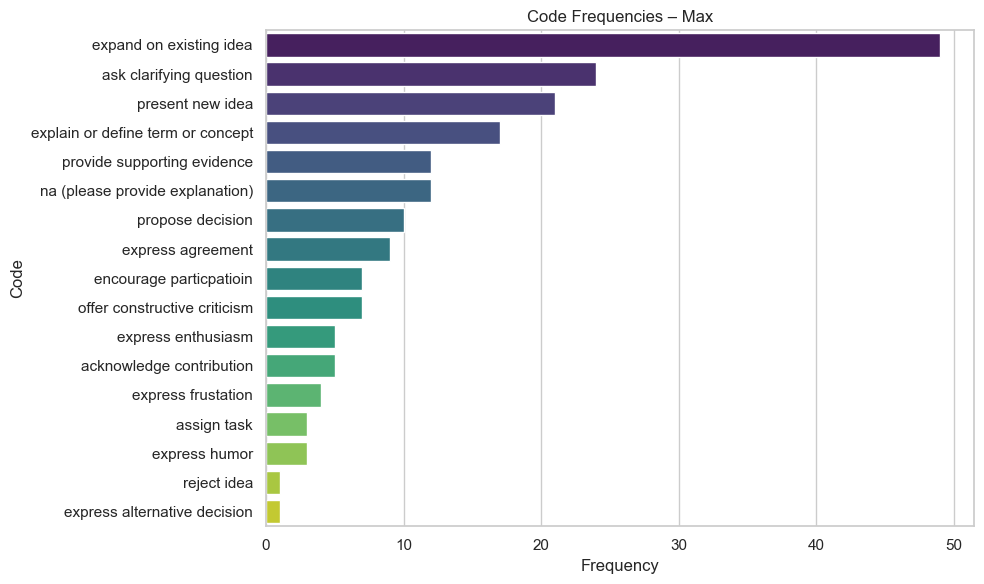


 Code Frequency Stats for Evey


,code,count,mean_per_utterance,median_per_utterance,std_per_utterance
2,expand on existing idea,51,1.0,1.0,0.0
7,explain or define term or concept,35,1.0,1.0,0.0
9,provide supporting evidence,32,1.0,1.0,0.0
0,acknowledge contribution,21,1.0,1.0,0.0
5,propose decision,21,1.0,1.0,0.0
4,present new idea,16,1.0,1.0,0.0
3,ask clarifying question,15,1.0,1.0,0.0
1,na (please provide explanation),13,1.0,1.0,0.0
8,express agreement,11,1.0,1.0,0.0
10,express enthusiasm,11,1.0,1.0,0.0


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_31697/2441088057.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='code', x='count', data=df_stats, palette='viridis')


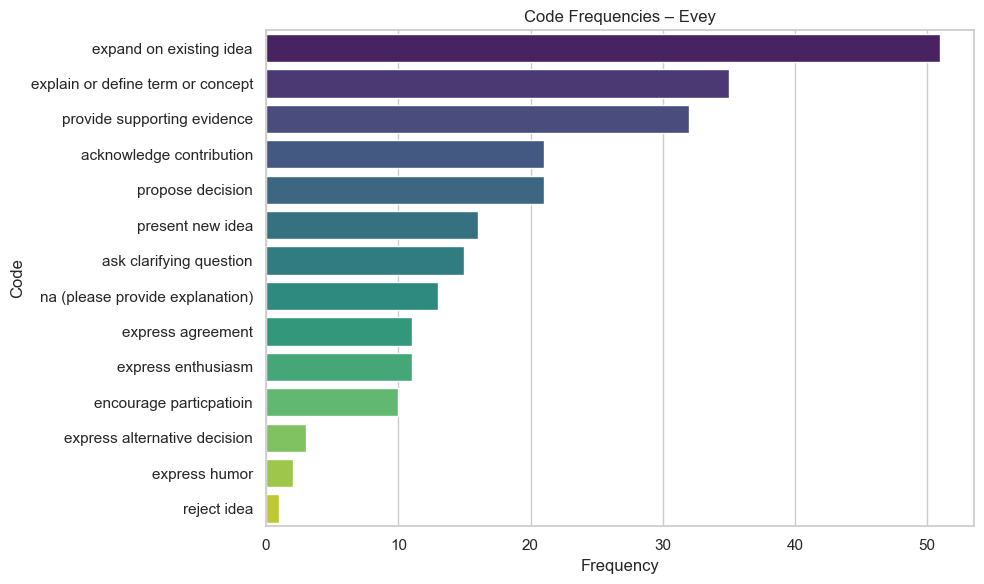


 Code Frequency Stats for Gemini


,code,count,mean_per_utterance,median_per_utterance,std_per_utterance
7,expand on existing idea,99,1.0,1.0,0.0
1,explain or define term or concept,78,1.0,1.0,0.0
2,present new idea,60,1.0,1.0,0.0
4,provide supporting evidence,52,1.0,1.0,0.0
5,propose decision,30,1.0,1.0,0.0
6,ask clarifying question,29,1.0,1.0,0.0
0,acknowledge contribution,25,1.0,1.0,0.0
8,express enthusiasm,15,1.0,1.0,0.0
11,express agreement,14,1.0,1.0,0.0
9,encourage particpatioin,12,1.0,1.0,0.0


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_31697/2441088057.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='code', x='count', data=df_stats, palette='viridis')


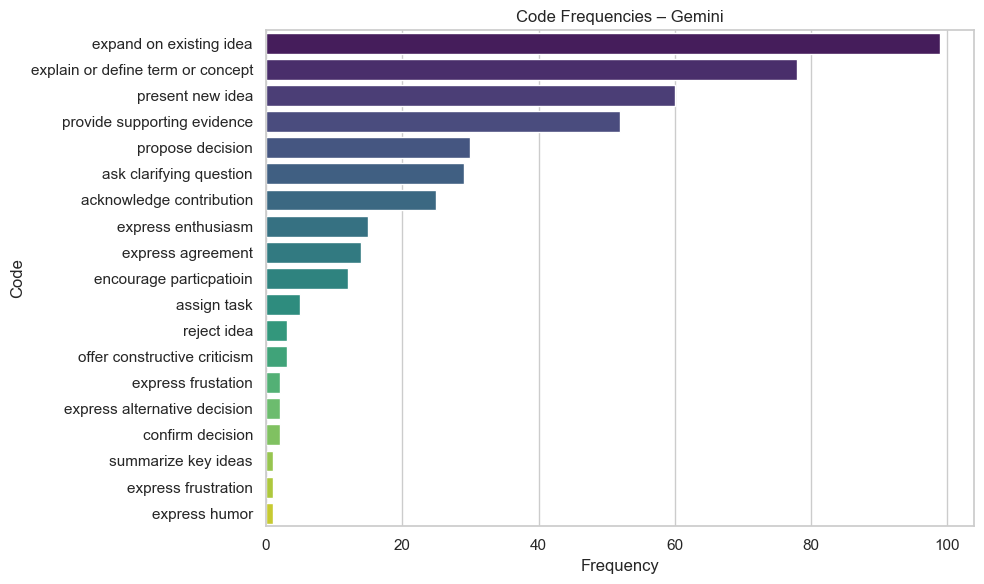

In [14]:
# Step 1 - Annotation Stats for Each Coder

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Helper: Get frequency of each code
def get_code_stats(df, coder_label):
    all_codes = [code for lst in df['annotation_list'] for code in lst]
    code_counts = Counter(all_codes)
    df_stats = pd.DataFrame.from_dict(code_counts, orient='index', columns=['count'])
    df_stats.index.name = 'code'
    df_stats.reset_index(inplace=True)

    # Compute mean, median, std — based on per-utterance code counts
    per_utterance_counts = df['annotation_list'].apply(len)
    df_stats['mean_per_utterance'] = per_utterance_counts.mean()
    df_stats['median_per_utterance'] = per_utterance_counts.median()
    df_stats['std_per_utterance'] = per_utterance_counts.std()

    df_stats = df_stats.sort_values(by='count', ascending=False)
    
    print(f"\n Code Frequency Stats for {coder_label}")
    display(df_stats)

    # Bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(y='code', x='count', data=df_stats, palette='viridis')
    plt.title(f'Code Frequencies – {coder_label}')
    plt.xlabel('Frequency')
    plt.ylabel('Code')
    plt.tight_layout()
    plt.show()

    return df_stats

# Run for each coder
stats_max = get_code_stats(df_max, 'Max')
stats_evey = get_code_stats(df_evey, 'Evey')
stats_gemini = get_code_stats(df_gemini, 'Gemini')


## Part 1B

In [8]:
excel_path = '../Data/sampled video verification (Max).xlsx'
xls = pd.ExcelFile(excel_path)
print(xls.sheet_names)

['Instructions', 'Codebook', 'Step 1 Annotate', 'Step 2 Verify (ONLY AFTER step ']


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_40128/2079780514.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pair_df, y='pair_str', x='count', palette='mako')


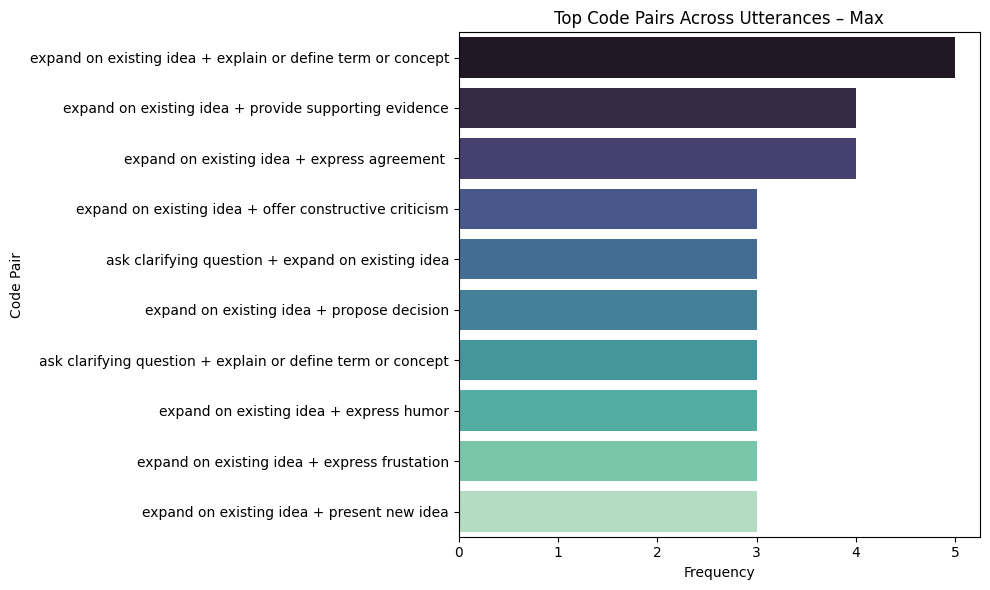

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_40128/2079780514.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pair_df, y='pair_str', x='count', palette='mako')


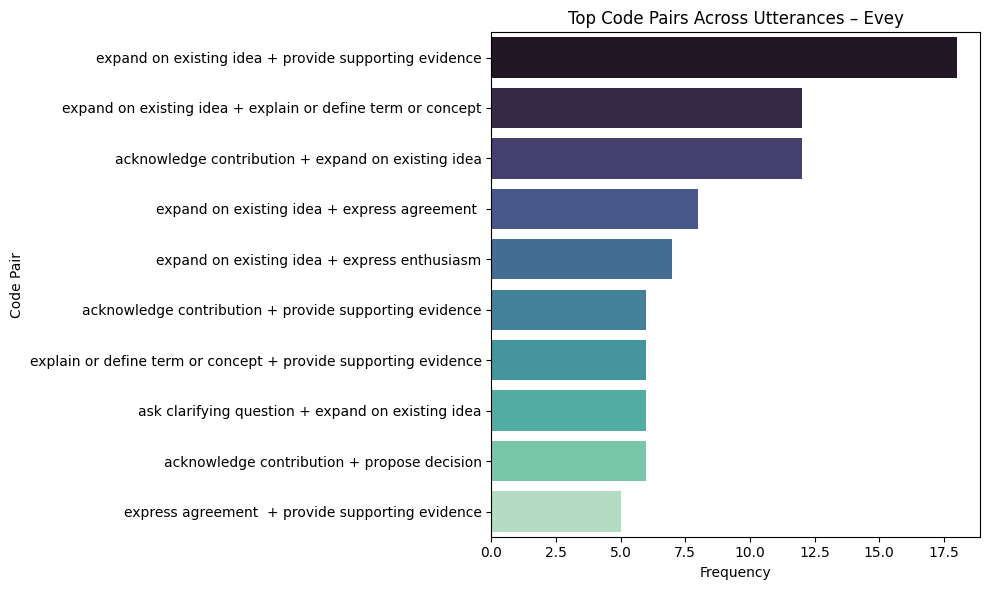

In [ ]:
# HUMAN CODERS PART 1B


import pandas as pd

from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def plot_common_code_pairs(df, coder_label, top_n=10):
    """
    Plots the top N most common code pairs from multi-label utterances.

    Parameters:
    - df: DataFrame with a column 'annotation_list' (list of codes per utterance)
    - coder_label: string label for the plot title
    - top_n: number of top pairs to show
    """

    # Collect all code pairs from utterances that have multiple codes
    all_pairs = []
    for codes in df['annotation_list']:
        if len(codes) > 1:
            sorted_codes = sorted(codes)
            pairs = combinations(sorted_codes, 2)
            all_pairs.extend(pairs)

    if not all_pairs:
        print(f"No multi-code utterances found for {coder_label}. Skipping pair plot.")
        return

    # Count and convert to DataFrame
    pair_counts = Counter(all_pairs)
    pair_df = pd.DataFrame(pair_counts.items(), columns=['code_pair', 'count'])
    pair_df = pair_df.sort_values(by='count', ascending=False).head(top_n)

    # Convert tuple to readable string for plotting
    pair_df['pair_str'] = pair_df['code_pair'].apply(lambda x: f"{x[0]} + {x[1]}")

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=pair_df, y='pair_str', x='count', palette='mako')
    plt.title(f'Top Code Pairs Across Utterances – {coder_label}')
    plt.xlabel('Frequency')
    plt.ylabel('Code Pair')
    plt.tight_layout()
    plt.show()


# Load Max's Excel file from the correct sheet
excel_path_max = '../Data/sampled video verification (Max).xlsx'
df_max_raw = pd.read_excel(excel_path_max, sheet_name='Step 1 Annotate')

# Identify all annotation columns (D, F, H, J → typically: 'annotation', 'annotation.1', etc.)
annotation_cols_max = [col for col in df_max_raw.columns if col.startswith('annotation')]

# Combine annotations into list per row
df_max_raw['annotation_list'] = df_max_raw[annotation_cols_max].values.tolist()
df_max_raw['annotation_list'] = df_max_raw['annotation_list'].apply(lambda x: [a for a in x if pd.notna(a)])

# Group by timestamp to consolidate multiple rows per clip
df_max = df_max_raw.groupby('timestamp')['annotation_list'].apply(
    lambda lists: [code for sublist in lists for code in sublist]
).reset_index()

# Load Evey's Excel file
excel_path_evey = '../Data/sampled video verification (Evey).xlsx'
df_evey_raw = pd.read_excel(excel_path_evey, sheet_name='Step 1 Annotate')

annotation_cols_evey = [col for col in df_evey_raw.columns if col.startswith('annotation')]
df_evey_raw['annotation_list'] = df_evey_raw[annotation_cols_evey].values.tolist()
df_evey_raw['annotation_list'] = df_evey_raw['annotation_list'].apply(lambda x: [a for a in x if pd.notna(a)])

df_evey = df_evey_raw.groupby('timestamp')['annotation_list'].apply(
    lambda lists: [code for sublist in lists for code in sublist]
).reset_index()

plot_common_code_pairs(df_max, 'Max')
plot_common_code_pairs(df_evey, 'Evey')


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_40128/512867723.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pair_df, y='pair_str', x='count', palette='mako')


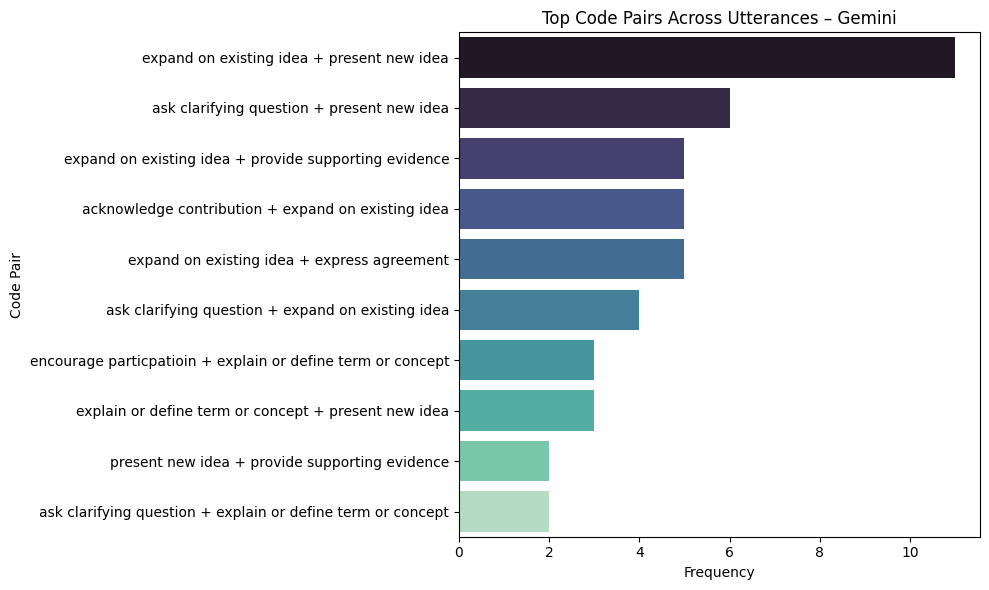

In [ ]:
import pandas as pd
import ast
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1B: Load and Process Gemini Annotations ===
gemini_path = '../Data/sampled_verification (gemini).xlsx'
df_gemini_raw = pd.read_excel(gemini_path, sheet_name='Sheet1')  # or adjust if named differently

# Drop rows with missing annotations
df_gemini_raw = df_gemini_raw[['timestamp', 'annotations']].dropna()

# Safely parse each annotation cell into a list of code-label dictionaries
def extract_code_labels(annotation_str):
    try:
        parsed = ast.literal_eval(annotation_str)
        return [list(d.keys())[0] for d in parsed if isinstance(d, dict)]
    except:
        return []

df_gemini_raw['annotation_list'] = df_gemini_raw['annotations'].apply(extract_code_labels)

# Group by timestamp
df_gemini = df_gemini_raw.groupby('timestamp')['annotation_list'].apply(
    lambda lists: [code for sublist in lists for code in sublist]
).reset_index()

# === Use existing plot function ===
def plot_common_code_pairs(df, coder_label, top_n=10):
    all_pairs = []
    for codes in df['annotation_list']:
        if len(codes) > 1:
            sorted_codes = sorted(codes)
            pairs = combinations(sorted_codes, 2)
            all_pairs.extend(pairs)

    if not all_pairs:
        print(f"No multi-code utterances found for {coder_label}. Skipping pair plot.")
        return

    pair_counts = Counter(all_pairs)
    pair_df = pd.DataFrame(pair_counts.items(), columns=['code_pair', 'count'])
    pair_df = pair_df.sort_values(by='count', ascending=False).head(top_n)
    pair_df['pair_str'] = pair_df['code_pair'].apply(lambda x: f"{x[0]} + {x[1]}")

    plt.figure(figsize=(10, 6))
    sns.barplot(data=pair_df, y='pair_str', x='count', palette='mako')
    plt.title(f'Top Code Pairs Across Utterances – {coder_label}')
    plt.xlabel('Frequency')
    plt.ylabel('Code Pair')
    plt.tight_layout()
    plt.show()

# Plot Gemini
plot_common_code_pairs(df_gemini, 'Gemini')


## Part 2A

In [ ]:
from sklearn.metrics import cohen_kappa_score
import pandas as pd

def compute_kappa_and_agreement(df1, df2, label1="coder1", label2="coder2"):
    merged = df1[['utterance_id', 'annotation_list']].merge(
        df2[['utterance_id', 'annotation_list']],
        on='utterance_id',
        suffixes=(f'_{label1}', f'_{label2}')
    )

    print(f"\nComparing: {label1} vs {label2}")
    print(f"→ Overlapping utterances: {len(merged)}")

    if len(merged) == 0:
        print("No overlapping utterances.")
        return pd.DataFrame()

    # Get all unique codes across both coders
    all_codes = sorted(set(
        code for col in [f'annotation_list_{label1}', f'annotation_list_{label2}']
        for lst in merged[col] for code in lst
    ))

    results = []

    print("\nPer-code Scores (Kappa + Simple Agreement):")
    for code in all_codes:
        bin1 = merged[f'annotation_list_{label1}'].apply(lambda lst: int(code in lst))
        bin2 = merged[f'annotation_list_{label2}'].apply(lambda lst: int(code in lst))

        # Cohen's Kappa (quadratic weighted)
        kappa = cohen_kappa_score(bin1, bin2, weights='quadratic')

        # Simple Agreement
        TP = ((bin1 == 1) & (bin2 == 1)).sum()
        TN = ((bin1 == 0) & (bin2 == 0)).sum()
        FP = ((bin1 == 0) & (bin2 == 1)).sum()
        FN = ((bin1 == 1) & (bin2 == 0)).sum()
        total = TP + TN + FP + FN
        agreement = (TP + TN) / total if total else float('nan')

        results.append((code, kappa, agreement))
        print(f"{code:<35}: kappa={kappa:.3f}  agreement={agreement:.3f}  (TP={TP}, TN={TN}, FP={FP}, FN={FN})")

    return pd.DataFrame(results, columns=['code', 'kappa_score', 'simple_agreement']) \
             .sort_values(by='simple_agreement', ascending=False)


df_scores_max_evey = compute_kappa_and_agreement(df_max, df_evey, label1='max', label2='evey')




Comparing: max vs evey
→ Overlapping utterances: 373

Per-code Scores (Kappa + Simple Agreement):
acknowledge contribution           : kappa=0.092  agreement=0.893  (TP=3, TN=330, FP=33, FN=7)
ask clarifying question            : kappa=0.160  agreement=0.858  (TP=8, TN=312, FP=17, FN=36)
assign task                        : kappa=0.000  agreement=0.984  (TP=0, TN=367, FP=0, FN=6)
encourage particpatioin            : kappa=0.160  agreement=0.933  (TP=3, TN=345, FP=16, FN=9)
expand on existing idea            : kappa=0.043  agreement=0.651  (TP=23, TN=220, FP=49, FN=81)
explain or define term or concept  : kappa=0.114  agreement=0.820  (TP=9, TN=297, FP=41, FN=26)
express agreement                  : kappa=0.224  agreement=0.925  (TP=5, TN=340, FP=12, FN=16)
express alternative decision       : kappa=-0.004  agreement=0.987  (TP=0, TN=368, FP=4, FN=1)
express enthusiasm                 : kappa=-0.026  agreement=0.941  (TP=0, TN=351, FP=15, FN=7)
express frustation                 : kapp

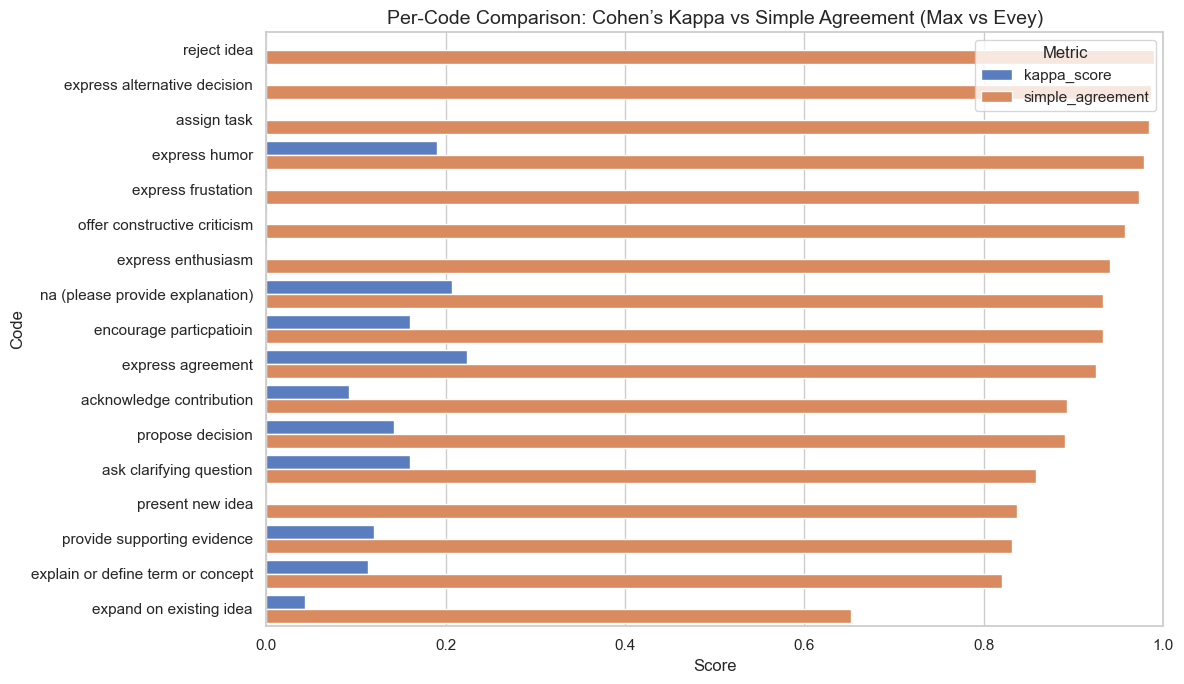

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up
df_plot = df_scores_max_evey.melt(id_vars='code', value_vars=['kappa_score', 'simple_agreement'],
                                   var_name='metric', value_name='score')

plt.figure(figsize=(12, 7))
sns.barplot(data=df_plot, x='score', y='code', hue='metric', palette='muted')

plt.title('Per-Code Comparison: Cohen’s Kappa vs Simple Agreement (Max vs Evey)', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Code')
plt.xlim(0, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


In [15]:
df_scores_evey_gemini = compute_kappa_and_agreement(df_evey, df_gemini, label1='evey', label2='gemini')
df_scores_max_gemini = compute_kappa_and_agreement(df_max, df_gemini, label1='max', label2='gemini')



Comparing: evey vs gemini
→ Overlapping utterances: 203

Per-code Scores (Kappa + Simple Agreement):
acknowledge contribution           : kappa=0.243  agreement=0.887  (TP=5, TN=175, FP=9, FN=14)
ask clarifying question            : kappa=0.150  agreement=0.887  (TP=3, TN=177, FP=15, FN=8)
assign task                        : kappa=0.000  agreement=0.980  (TP=0, TN=199, FP=4, FN=0)
confirm decision                   : kappa=0.000  agreement=0.990  (TP=0, TN=201, FP=2, FN=0)
encourage particpatioin            : kappa=0.159  agreement=0.892  (TP=3, TN=178, FP=8, FN=14)
expand on existing idea            : kappa=0.095  agreement=0.690  (TP=13, TN=127, FP=28, FN=35)
explain or define term or concept  : kappa=0.240  agreement=0.803  (TP=11, TN=152, FP=23, FN=17)
express agreement                  : kappa=-0.007  agreement=0.980  (TP=0, TN=199, FP=3, FN=1)
express alternative decision       : kappa=0.000  agreement=0.970  (TP=0, TN=197, FP=0, FN=6)
express enthusiasm                 : kappa

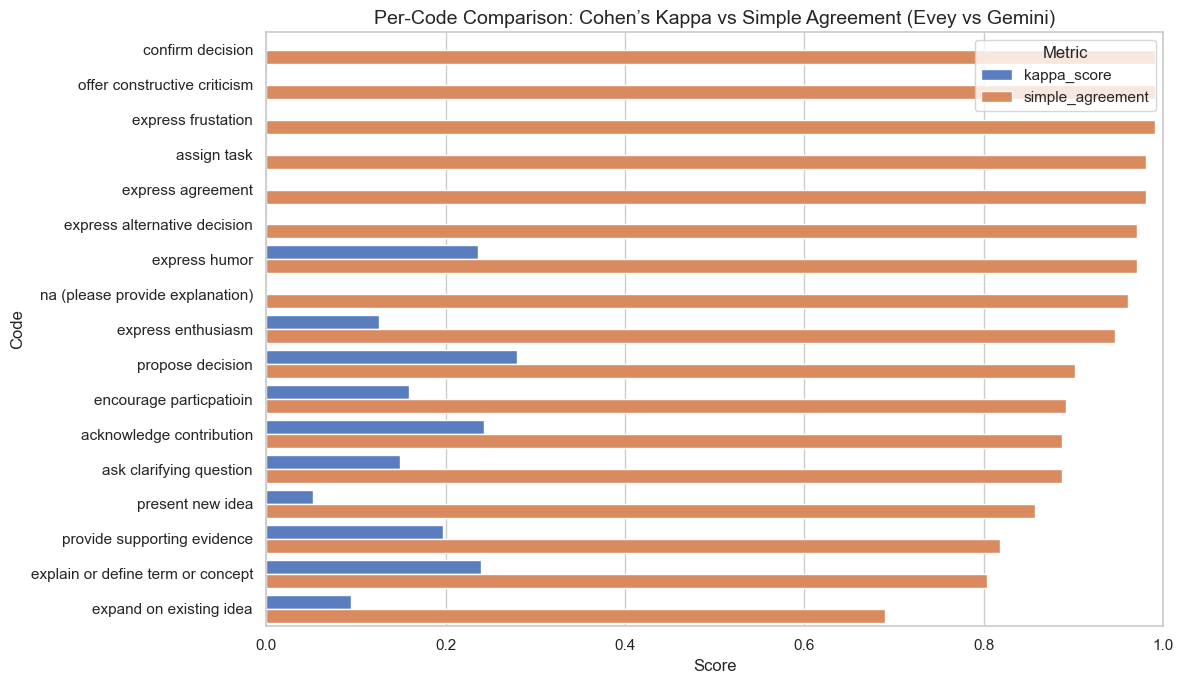

In [16]:
# evey vs. gemini plot

import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to long format for seaborn
df_plot_eg = df_scores_evey_gemini.melt(
    id_vars='code',
    value_vars=['kappa_score', 'simple_agreement'],
    var_name='metric',
    value_name='score'
)

# Create the plot
plt.figure(figsize=(12, 7))
sns.barplot(data=df_plot_eg, x='score', y='code', hue='metric', palette='muted')

plt.title('Per-Code Comparison: Cohen’s Kappa vs Simple Agreement (Evey vs Gemini)', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Code')
plt.xlim(0, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


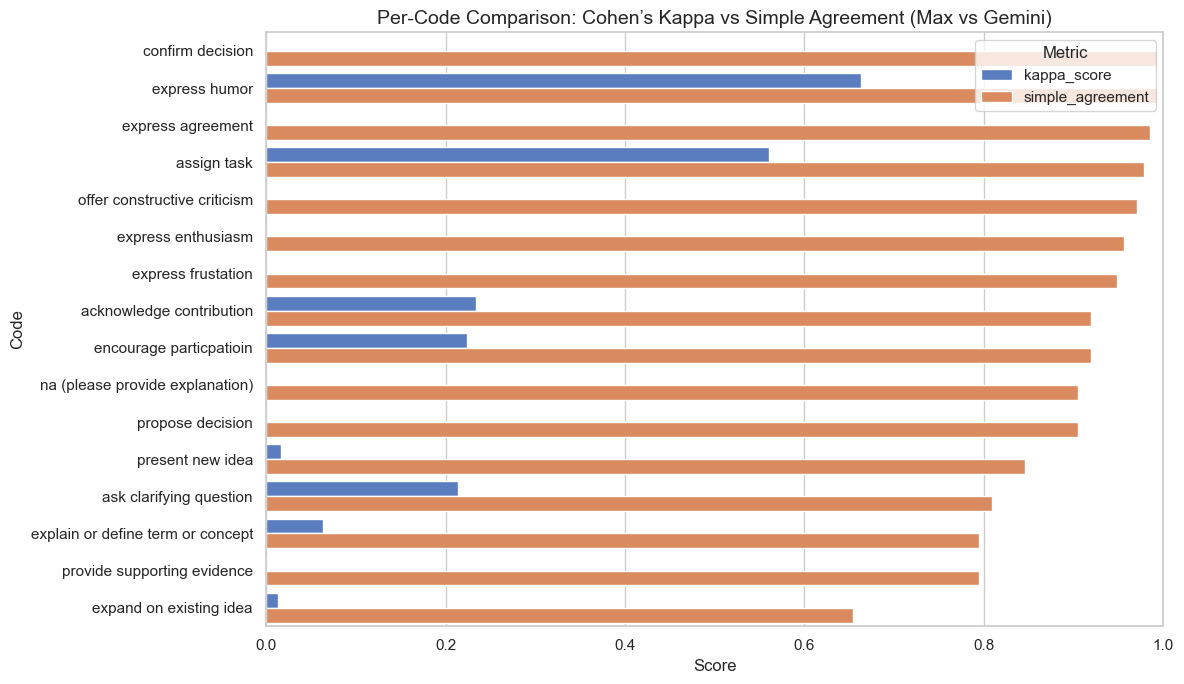

In [17]:
# max vs gemini plot

# Melt the DataFrame to long format
df_plot_mg = df_scores_max_gemini.melt(
    id_vars='code',
    value_vars=['kappa_score', 'simple_agreement'],
    var_name='metric',
    value_name='score'
)

# Create the plot
plt.figure(figsize=(12, 7))
sns.barplot(data=df_plot_mg, x='score', y='code', hue='metric', palette='muted')

plt.title('Per-Code Comparison: Cohen’s Kappa vs Simple Agreement (Max vs Gemini)', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Code')
plt.xlim(0, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


## Part 3A & 3B

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_31697/1330085446.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_kappa, x='kappa_score', y='code', palette='mako')


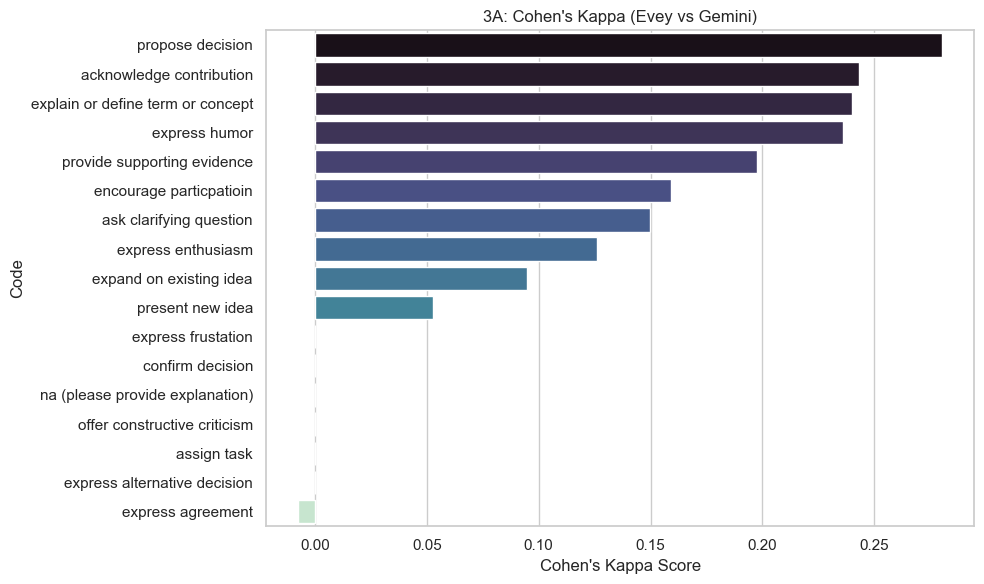

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_31697/1330085446.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_kappa, x='kappa_score', y='code', palette='mako')


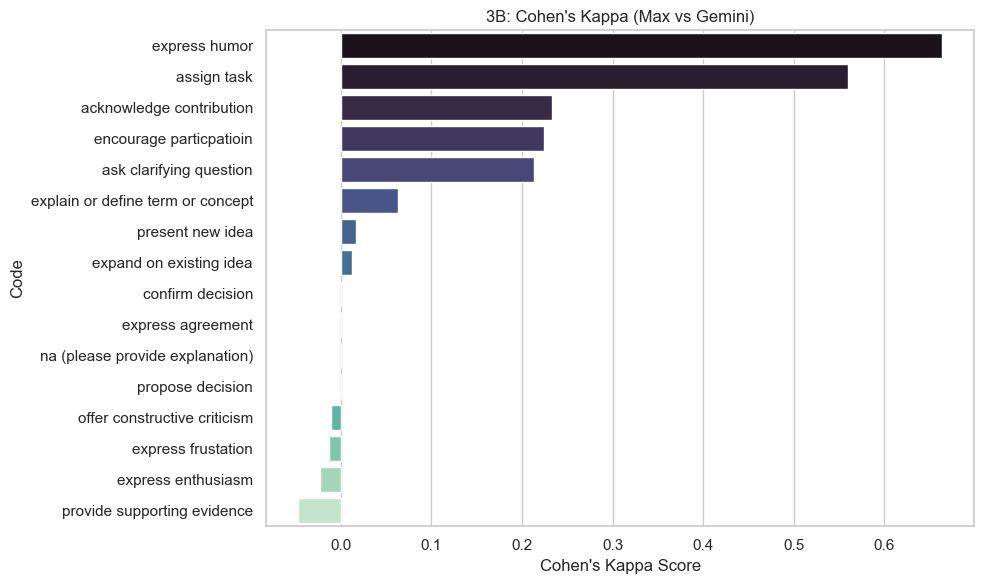

In [ ]:
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to compute Cohen’s Kappa (binary presence/absence) per code
def compute_kappa_per_code(df1, df2, coder1='Coder1', coder2='Coder2'):
    merged = df1[['utterance_id', 'annotation']].merge(
        df2[['utterance_id', 'annotation']],
        on='utterance_id',
        suffixes=(f"_{coder1}", f"_{coder2}")
    )

    annotations_1 = merged[f'annotation_{coder1}'].fillna('none').astype(str).str.strip().str.lower()
    annotations_2 = merged[f'annotation_{coder2}'].fillna('none').astype(str).str.strip().str.lower()

    all_codes = sorted(set(annotations_1.unique()) | set(annotations_2.unique()))
    results = []
    for code in all_codes:
        bin1 = annotations_1.apply(lambda x: int(x == code))
        bin2 = annotations_2.apply(lambda x: int(x == code))
        score = cohen_kappa_score(bin1, bin2)  # binary comparison
        results.append((code, score))

    df_results = pd.DataFrame(results, columns=['code', 'kappa_score']).sort_values(by='kappa_score', ascending=False)
    return df_results

# Function to plot results
def plot_kappa_results(df_kappa, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_kappa, x='kappa_score', y='code', palette='mako')
    plt.title(title)
    plt.xlabel("Cohen's Kappa Score")
    plt.ylabel("Code")
    plt.tight_layout()
    plt.show()

# 3A: Evey vs Gemini
df_kappa_evey_gemini = compute_kappa_per_code(df_evey, df_gemini, coder1='Evey', coder2='Gemini')
plot_kappa_results(df_kappa_evey_gemini, "3A: Cohen's Kappa (Evey vs Gemini)")

# 3B: Max vs Gemini
df_kappa_max_gemini = compute_kappa_per_code(df_max, df_gemini, coder1='Max', coder2='Gemini')
plot_kappa_results(df_kappa_max_gemini, "3B: Cohen's Kappa (Max vs Gemini)")


## Extra Notes

Matt's suggestion (calculating Cohen's Kappa) - two differing coder's annotation: 

"Here we'd just look at agreement. So how often two codes co-occur. In other words, if it occurs in human annotation, how often does it also occur in Gemini Annotation."